<a href="https://colab.research.google.com/github/rockey1006/Variational-Autoencoders/blob/master/LDF_with_Resnet%2BVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.applications.resnet import ResNet101
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
base_model = ResNet101(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


Using TensorFlow backend.














179650560/179648224 [==============================] - 2s 0us/step


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
import tarfile
tar = tarfile.open('/content/drive/My Drive/lfw.tgz')
names = tar.getnames()
for name in names:
  tar.extract(name,path='/content/lfw')
tar.close()

In [9]:
paths_path = "/content/lfw/lfw/*/*"
paths_list = glob.glob(paths_path)
paths_list[:1]
labels = [p.split("/")[-1].split("00")[0].replace("_", " ").rstrip() for p in paths_list]
labels[:5]
len(labels)#13233 images
#5749 people
#1680 people with two or more images

13233

In [10]:
face_labels = pd.Series(labels)
top_faces = face_labels.value_counts()[:10]
top_face_names = top_faces.index
top_face_names


Index(['Tony Blair', 'Colin Powell', 'George W Bush', 'Donald Rumsfeld',
       'Gerhard Schroeder', 'Ariel Sharon', 'Hugo Chavez', 'Junichiro Koizumi',
       'Jean Chretien', 'John Ashcroft'],
      dtype='object')

In [11]:

face_lookup = pd.Series(top_face_names)
face_lookup = face_lookup.reset_index()
face_lookup.columns = ['num_label', 'name']
face_lookup.head()
fac_labels = face_labels.reset_index()
fac_labels.columns = ['idx', 'name']
fac_labels.head()
mgd = pd.merge(fac_labels, face_lookup, how="inner", left_on='name', right_on="name")
mgd.head()
mgd.shape

(811, 3)

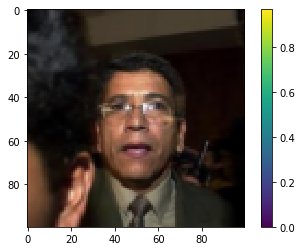

In [16]:
df = mgd.set_index("idx")
df = mgd['name']
y = mgd['num_label'] 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, 
                                                    random_state=42)
img_train = [imread(img) for i, img in enumerate(paths_list) if i in X_train.index]
img_test = [imread(img) for i, img in enumerate(paths_list) if i in X_test.index]

def resize_image(img):
    img = resize(img, (100, 100), anti_aliasing=True)
    return img

def rescale_image(img):
    return img /255

#First resize...
img_train = [resize_image(i) for i in img_train]
img_test = [resize_image(i) for i in img_test]

#...then output a sample to check it has worked...
io = resize_image(img_train[0])
plt.figure()
plt.imshow(io)
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
len(img_train)
#len(img_test)

648

In [14]:
print(img_train[0].shape)

(224, 224, 3)


In [0]:
#img = image.load_img(img_path,target_size=(224, 224))
features=[]
for i, element in enumerate(img_train):
  x = image.img_to_array(element)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features.append(model.predict(x))
  


In [0]:
features_test=[]
for i, element in enumerate(img_test):
  x = image.img_to_array(element)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features_test.append(model.predict(x))

In [0]:
len(features)

648

In [0]:
len(features_test)

163

In [0]:
len(y_train)

648

In [0]:
len(y_test)

163

In [0]:
print(features[2])


[[0.8473449 0.        0.        ... 0.        0.        0.       ]]


In [0]:
print(features[2].shape)


(1, 2048)


In [0]:
batch_size = 100 
original_dim = 30000
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)#中间结果h，隐藏层256个结点，激活函数relu
z_mean = Dense(latent_dim)(h)#隐变量输出层1有2 个结点
z_log_var = Dense(latent_dim)(h)#隐变量输出层2有2个结点

In [24]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#输入是z_mean和z_log_var，输出是z
decoder_h = Dense(intermediate_dim, activation='relu')#隐藏层
decoder_mean = Dense(original_dim, activation='sigmoid')#输出层
h_decoded = decoder_h(z)#中间值
x_decoded_mean = decoder_mean(h_decoded)#输出值
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL+交叉熵
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) #复杂损失函数所以不在compile声明，而使用add_loss
vae.compile(optimizer='rmsprop') #用于配置训练模型。

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

vae.summary() #model.summary()：打印出模型概况，它实际调用的是keras.utils.print_summary


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30000)        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          7680256     input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            514         dense_6[0][0]                    
____________________________________________________________________________________________

In [20]:
x_train = np.array(features) 
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(648, 100, 100, 3)
(648, 30000)


In [25]:
x_train = np.array(img_train) 
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(648, 100, 100, 3)
(648, 30000)


In [26]:
x_test = np.array(img_test) 
print(x_test.shape)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))#改变shape
print(x_test.shape)

(163, 100, 100, 3)
(163, 30000)


In [27]:
vae.fit(x_train,#算输出和输入分布的差异所以没有y
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))



Train on 648 samples, validate on 163 samples
Epoch 1/50
 - 5s - loss: 39886.1094 - val_loss: 20435.7491
Epoch 2/50
 - 3s - loss: 20399.0414 - val_loss: 20128.0605
Epoch 3/50
 - 3s - loss: 20102.0732 - val_loss: 19361.9615
Epoch 4/50
 - 3s - loss: 19947.8549 - val_loss: 19062.4088
Epoch 5/50
 - 3s - loss: 426510665.1210 - val_loss: 21920.5762
Epoch 6/50
 - 3s - loss: 21514.2877 - val_loss: 20685.5893
Epoch 7/50
 - 3s - loss: 20216.2846 - val_loss: 19271.6354
Epoch 8/50
 - 3s - loss: 18938.5090 - val_loss: 18839.9671
Epoch 9/50
 - 3s - loss: 18749.9679 - val_loss: 18825.5247
Epoch 10/50
 - 3s - loss: 18764.6797 - val_loss: 18535.1715
Epoch 11/50
 - 3s - loss: 18599.9493 - val_loss: 18496.5647
Epoch 12/50
 - 3s - loss: 18702.7648 - val_loss: 18510.5008
Epoch 13/50
 - 3s - loss: 18468.3630 - val_loss: 18659.3803
Epoch 14/50
 - 3s - loss: 18412.7485 - val_loss: 18738.3431
Epoch 15/50
 - 3s - loss: 18687.9255 - val_loss: 18366.3372
Epoch 16/50
 - 3s - loss: 18325.1418 - val_loss: 19154.98

In [0]:
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [29]:
plt.figure(figsize=(18, 16), dpi=200)#Create a new figure.

<Figure size 3600x3200 with 0 Axes>

<Figure size 3600x3200 with 0 Axes>

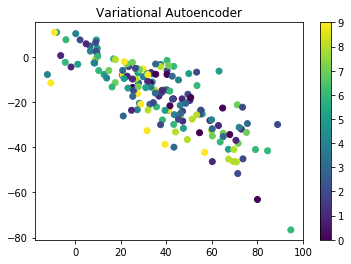

In [30]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()
